**DS514/515 Final Project**

# หัวข้อ : **Shopping Behavior**

**สมาชิก:**
<br>1) เรือโท จีรยุทธ วงศ์ไตรรัตน์ (ID: 68199160257)
<br>2) นายชญานนท์ สิริลัภนานนท์ (ID : 68199160258)
<br>2) นายวิวรรธน์ เกียรติเฉลิมพร (ID : 68199160299)
<br><br>
**Dataset:** This is a dataset of customer purchasing behavior (Retail/E-commerce Transactions) from 3,900 customers, covering details across three main dimensions:

Customer Demographics: Age, Gender, Location

Transaction Information: Item/Category, Purchase Amount, Color, Size, Season

Behavior & Loyalty: Subscription status, Use of discount/promo codes, Payment method, Purchase frequency, and Review rating <br>
**link Source:** https://www.kaggle.com/datasets/zubairdhuddi/shopping-dataset?select=shopping_behavior_updated.csv

<br>
วัตถุประสงค์ : สร้างโมเดลจำแนกประเภท (Classification Model) ที่สามารถระบุตัวตนของ "ว่าที่ลูกค้าเกรด A" (Hot Leads) หรือกลุ่มคนที่ "ยังไม่ได้สมัครสมาชิก" แต่มีพฤติกรรมการซื้อ "เหมือนสมาชิก"
เพื่อนำรายชื่อนี้ส่งต่อให้ทีมการตลาดทำแคมเปญกระตุ้นยอดสมัคร (Lead Scoring Strategy)

# Import Packages

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Import Dataset

In [2]:
shopping_df = pd.read_csv('/content/shopping.csv')

# Explore Data Analysis






In [3]:
shopping_df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [4]:
shopping_df.shape

(3900, 18)

In [5]:
shopping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [6]:
shopping_df.isnull().sum()

,0
Customer ID,0
Age,0
Gender,0
Item Purchased,0
Category,0
Purchase Amount (USD),0
Location,0
Size,0
Color,0
Season,0


# Data pre-processing

*   Data Cleaning ตัดข้อมูลที่ไม่สำคัญออก
*   ปรับข้อมูลที่เป็น Text to numbers เพื่อทำให้สามารถนำมาคำนวณได้
*   แก้ไข one-Hot Encoding: สำหรับข้อมูลกลุ่มที่ไม่มีลำดับ (Nominal Data)

In [7]:
# ==========================================
# 1. เตรียมข้อมูล (Data Preprocessing)
# ==========================================
# ลบคอลัมน์ที่ไม่จำเป็น
shopping_df.drop(['Customer ID', 'Item Purchased', 'Location', 'Color'], axis=1, inplace=True)

# แปลงค่า Binary/Ordinal (Text -> Number)
shopping_df['Gender'] = shopping_df['Gender'].map({'Male': 0, 'Female': 1})
shopping_df['Subscription Status'] = shopping_df['Subscription Status'].map({'No': 0, 'Yes': 1})
shopping_df['Discount Applied'] = shopping_df['Discount Applied'].map({'No': 0, 'Yes': 1})
shopping_df['Promo Code Used'] = shopping_df['Promo Code Used'].map({'No': 0, 'Yes': 1})

# แปลง Size
shopping_df['Size'] = shopping_df['Size'].map({'S': 1, 'M': 2, 'L': 3, 'XL': 4})

# แปลงความถี่ (Frequency)
freq_map = {
    'Annually': 1, 'Quarterly': 4, 'Every 3 Months': 4,
    'Monthly': 12, 'Bi-Weekly': 26, 'Fortnightly': 26, 'Weekly': 52
}
shopping_df['Frequency of Purchases'] = shopping_df['Frequency of Purchases'].map(freq_map)

# One-Hot Encoding (ระเบิดคอลัมน์)
shopping_df = pd.get_dummies(shopping_df, columns=['Category', 'Season', 'Payment Method', 'Shipping Type'], drop_first=True, dtype=int)

In [8]:
shopping_df.head()

,Age,Gender,Purchase Amount (USD),Size,Review Rating,Subscription Status,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases,...,Payment Method_Cash,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_PayPal,Payment Method_Venmo,Shipping Type_Express,Shipping Type_Free Shipping,Shipping Type_Next Day Air,Shipping Type_Standard,Shipping Type_Store Pickup
0,55,0,53,3,3.1,1,1,1,14,26,...,0,0,0,0,1,1,0,0,0,0
1,19,0,64,3,3.1,1,1,1,2,26,...,1,0,0,0,0,1,0,0,0,0
2,50,0,73,1,3.1,1,1,1,23,52,...,0,1,0,0,0,0,1,0,0,0
3,21,0,90,2,3.5,1,1,1,49,52,...,0,0,0,1,0,0,0,1,0,0
4,45,0,49,2,2.7,1,1,1,31,1,...,0,0,0,1,0,0,1,0,0,0


In [9]:
shopping_df.shape

(3900, 26)

# สร้างโมเดล : Linear-Logistic Regression

*   กำหนด "เป้าหมาย" (Target) และ "ตัวแปรต้น" (Feature)
*   แบ่งข้อมูล 80/20
*   สร้าง Classification Report และ confusion_matrix








In [10]:
# ==========================================
# 2. สร้างและเทรนโมเดล (Training)
# ==========================================
# กำหนดเป้าหมาย (y) คือ 'Subscription Status'
X = shopping_df.drop('Subscription Status', axis=1)
y = shopping_df['Subscription Status']

# แบ่งข้อมูล (80% สอน / 20% สอบ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_model = LogisticRegression(max_iter=1000, random_state=42)
clf_model.fit(X_train, y_train)

# เช็คความแม่นยำ
acc = accuracy_score(y_test, clf_model.predict(X_test))
print(f"✅ โมเดล Logistic ความแม่นยำอยู่ที่: {acc*100:.2f}%")

✅ โมเดล Logistic ความแม่นยำอยู่ที่: 82.56%


📊 Linear Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       558
           1       0.62      0.99      0.76       222

    accuracy                           0.83       780
   macro avg       0.81      0.88      0.81       780
weighted avg       0.89      0.83      0.83       780



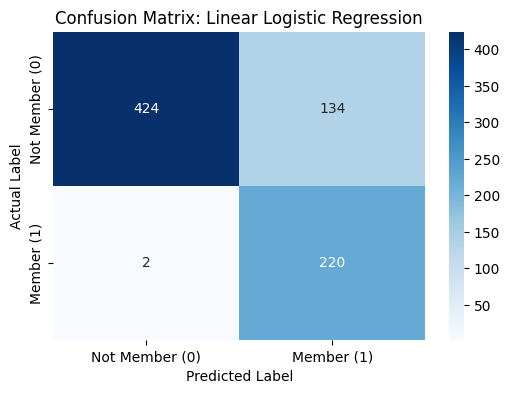

In [11]:
# 1. ให้โมเดลทำนายผล (Predict)
y_pred_linear = clf_model.predict(X_test)

# 2. ปริ้นท์ตารางรายงานผล (Classification Report)
print("📊 Linear Logistic Regression Report:")
print(classification_report(y_test, y_pred_linear))

# 3. สร้างตารางจับผิด (Confusion Matrix)
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred_linear)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Member (0)', 'Member (1)'],
            yticklabels=['Not Member (0)', 'Member (1)'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix: Linear Logistic Regression')
plt.show()

ประสิทธิภาพโดยรวม (Overall Performance)

*   ความแม่นยำ (Accuracy) = 83%
-> โมเดลสามารถทายสถานะลูกค้าได้ถูกต้องถึง 83 จาก 100 คน

*   Recall = 99%
-> หากมีสมาชิกตัวจริงเดินเข้ามา 100 คน โมเดลของเราสามารถตรวจจับได้ถึง 99 คน ผิดไปเพียง 1 คนเท่านั้น

*   Precision = 62%
-> โมเดลทายว่าเป็นสมาชิก 100 ครั้ง จะเป็นสมาชิกตัวจริง 62 ครั้ง อีก 38 ครั้งคือคนทั่วไป


# สร้างโมเดล : Non-Linear Logistic Regession (Polynomial Feature)


✅ Polynomial Logistic (Degree 2) Accuracy: 81.67%
--------------------------------------------------
📊 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       558
           1       0.66      0.74      0.70       222

    accuracy                           0.82       780
   macro avg       0.77      0.79      0.78       780
weighted avg       0.83      0.82      0.82       780



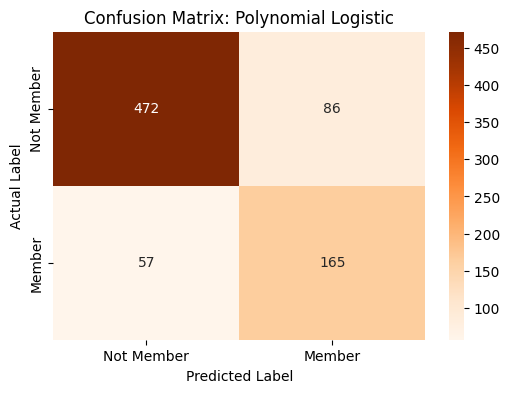

In [12]:
# 1. สร้าง Pipeline (Polynomial -> Scale -> Logistic)
# ใช้ degree=2 เพื่อสร้างเส้นโค้ง
# เพิ่ม max_iter=3000
poly_log_model = make_pipeline(
    PolynomialFeatures(degree=2),
    StandardScaler(),
    LogisticRegression(max_iter=3000, random_state=42)
)

# 2. เทรนโมเดล
poly_log_model.fit(X_train, y_train)

# 3. เก็บผลคะแนน (Save Score)
acc_poly = accuracy_score(y_test, poly_log_model.predict(X_test))

# 4. แสดงรายงานผล
print(f"\n✅ Polynomial Logistic (Degree 2) Accuracy: {acc_poly*100:.2f}%")
print("-" * 50)
print("📊 Detailed Classification Report:")
print(classification_report(y_test, poly_log_model.predict(X_test)))

# 5. สร้าง Confusion Matrix เทียบ
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, poly_log_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', # เปลี่ยนสีเป็นส้มให้ต่างจากอันแรก
            xticklabels=['Not Member', 'Member'],
            yticklabels=['Not Member', 'Member'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix: Polynomial Logistic')
plt.show()

ประสิทธิภาพโดยรวม (Overall Performance)  
สนใจ Negative (Class 0)

*   ความแม่นยำ (Accuracy) = 82%
-> โมเดลสามารถทายสถานะลูกค้าได้ถูกต้องถึง 83 จาก 100 คน

*   Recall = 74%


*   Precision = 66%


# สร้างโมเดล : KNN-Classification

In [13]:
# 1. สร้าง Pipeline (Scale -> KNN)
# ใช้ k=5 (ดูเพื่อนบ้าน 5 คน)
knn_model = make_pipeline(
    KNeighborsClassifier(n_neighbors=5)
)

In [14]:
# 2. เทรนโมเดล
knn_model.fit(X_train, y_train)

Pipeline(steps=[('kneighborsclassifier', KNeighborsClassifier())])


✅ KNN (k=5) Accuracy: 66.92%
--------------------------------------------------
📊 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.89      0.79       558
           1       0.30      0.13      0.18       222

    accuracy                           0.67       780
   macro avg       0.51      0.51      0.49       780
weighted avg       0.60      0.67      0.62       780



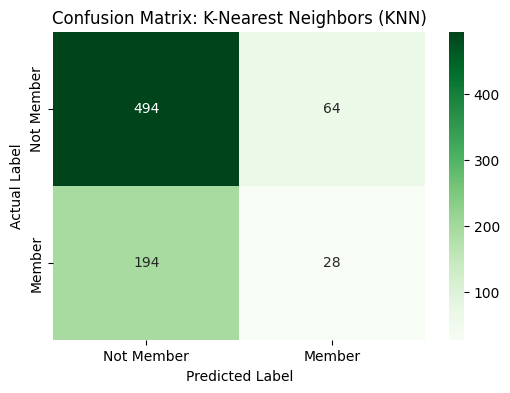

In [15]:
#3. เก็บผลคะแนน (Save Score)
acc_knn = accuracy_score(y_test, knn_model.predict(X_test))

# 4. แสดงรายงานผล
print(f"\n✅ KNN (k=5) Accuracy: {acc_knn*100:.2f}%")
print("-" * 50)
print("📊 Detailed Classification Report:")
print(classification_report(y_test, knn_model.predict(X_test)))

# 5. สร้าง Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, knn_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', # สีเขียว
            xticklabels=['Not Member', 'Member'],
            yticklabels=['Not Member', 'Member'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix: K-Nearest Neighbors (KNN)')
plt.show()

**กำหนดค่า K=5**

ประสิทธิภาพโดยรวม (Overall Performance)
สนใจ Negative (Class 0)

*   ความแม่นยำ (Accuracy) = 81%
-> โมเดลสามารถทายสถานะลูกค้าได้ถูกต้องถึง 81 จาก 100 คน

*   Recall = 89%


*   Precision = 72%

จึงทำการหาค่า K ที่ดีที่สุด

⏳ Testing K values from 5 to 100 (step=5)...


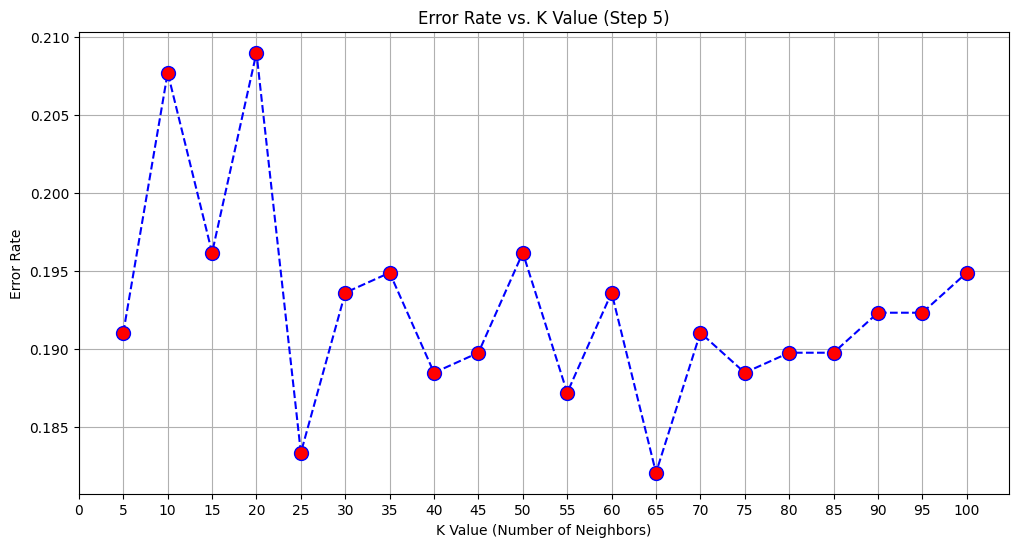

🏆 Best K Value (Min Error 0.1821) is: K = 65


In [16]:
# 1. กำหนดช่วงของ K (เริ่มที่ 5, ขยับทีละ 5, ไปจบที่ 100)
# range(5, 101, 5) จะได้ [5, 10, 15, ..., 100]
k_range = range(5, 101, 5)
error_rate = []
accuracy_list = []

print("⏳ Testing K values from 5 to 100 (step=5)...")

# 2. วนลูปทดสอบ
for i in k_range:
    # สร้าง Pipeline
    knn = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=i))
    knn.fit(X_train, y_train)

    # ทำนายผล
    pred_i = knn.predict(X_test)

    # เก็บค่า Error Rate
    error_rate.append(np.mean(pred_i != y_test))

# 3. วาดกราฟ
plt.figure(figsize=(12, 6)) # ปรับกราฟให้กว้างขึ้นนิดนึง

# พล็อตเส้น
plt.plot(k_range, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)

# ตั้งชื่อกราฟและแกน
plt.title('Error Rate vs. K Value (Step 5)')
plt.xlabel('K Value (Number of Neighbors)')
plt.ylabel('Error Rate')

# ปรับสเกลแกน X ให้โชว์ตัวเลขครบๆ (0 ถึง 100 ทีละ 5)
plt.xticks(np.arange(0, 101, step=5))

plt.grid(True)
plt.show()

# 4. หาค่า K ที่ดีที่สุดในรอบนี้
min_error = min(error_rate)
best_k = k_range[error_rate.index(min_error)]
print(f"🏆 Best K Value (Min Error {min_error:.4f}) is: K = {best_k}")

กำหนดค่า K เพิ่มขึ้นทีละ 5 จากช่วง 1-100 พบว่า ในช่วงดังกล่าว Trend เริ่มเปลี่ยนเป็นขาขึ้น จึงสรุปได้ว่าสามารถหาค่า K ที่ดีที่สุดจากช่วงดังกล่าวได้

In [ ]:
from sklearn.model_selection import GridSearchCV

# 1. สร้าง Pipeline รอไว้ (ยังไม่กำหนดค่า K)
knn_pipe = make_pipeline(StandardScaler(),KNeighborsClassifier())

# 2. กำหนดช่วงที่จะให้คอมพิวเตอร์สุ่มตรวจ
# ลองค่า K ตั้งแต่ 1 ถึง 100
# ลอง Weight 2 แบบ: 'uniform' (ปกติ) และ 'distance' (คนใกล้เสียงดังกว่า)
param_grid = {
    'kneighborsclassifier__n_neighbors': range(1, 101),
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

# 3. เริ่มค้นหา (Grid Search)
# cv=5 คือ แบ่งข้อมูลเป็น 5 ส่วน แล้วสลับกันสอบ 5 รอบ
print("⏳ กำลังรัน GridSearchCV เพื่อหาค่าที่ดีที่สุด... (รอสักครู่ครับ)")
grid = GridSearchCV(knn_pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# 4. เฉลยผลลัพธ์
print("-" * 50)
print(f"🏆 ค่า K ที่คอมพิวเตอร์บอกว่าดีที่สุด: {grid.best_params_}")
print(f"📈 ความแม่นยำเฉลี่ย (Cross-Validation Score): {grid.best_score_ * 100:.2f}%")
print("-" * 50)

# (แถม) เอาโมเดลที่ดีที่สุดมาทำนาย Test Set จริงๆ
best_model = grid.best_estimator_
test_acc = best_model.score(X_test, y_test)
print(f"🧪 ผลสอบกับข้อมูลชุด Test (Final Accuracy): {test_acc * 100:.2f}%")

⏳ กำลังรัน GridSearchCV เพื่อหาค่าที่ดีที่สุด... (รอสักครู่ครับ)


ค่า K ที่ดีที่สุดที่ได้คือ 13
นำค่า K ที่ได้มาทดสอบโมเดล

In [ ]:
# 1. สร้างและเทรนโมเดล KNN (K=13)
knn_13 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=13))
knn_13.fit(X_train, y_train)

# 2. ทำนายผล
y_pred_13 = knn_13.predict(X_test)

# 3. แสดงรายงานผล
acc_13 = accuracy_score(y_test, y_pred_13)
print(f"✅ KNN (K=13) Accuracy: {acc_13*100:.2f}%")
print("-" * 50)
print("📊 Classification Report:")
print(classification_report(y_test, y_pred_13))

# 4. สร้าง Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred_13)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Member', 'Member'],
            yticklabels=['Not Member', 'Member'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix: KNN (K=13)')
plt.show()

ประสิทธิภาพโดยรวม (Overall Performance) กำหนด K=13
สนใจ Negative (Class 0)

ความแม่นยำ (Accuracy) = 81% -> โมเดลสามารถทายสถานะลูกค้าได้ถูกต้องถึง 81 จาก 100 คน

Recall = 82%

Precision = 90%

# เปรียบเทียบ สรุปผลลัพธ์ที่ได้จากโมเดล

In [ ]:
# 1. สร้างตารางสรุปผล
data = {
    'Model': ['Linear Logistic', 'Polynomial (Deg 2)', 'KNN (K=13)'],
    'Accuracy (Overall)': [0.83, 0.82, 0.81],      # ความแม่นยำรวม
    'Recall (Not Member)':    [0.76, 0.85, 0.82],      # การเก็บตกคนที่ไม่ใช่สมาชิก (Class 0)
    'Precision (Not Member)': [1.00, 0.89, 0.90]       # ความชัวร์ของการทายว่าเป็นคนไม่ใช่สมาชิก (Class 0)
}

# แปลงข้อมูลให้อยู่ในรูปแบบที่วาดกราฟง่าย (Long Format)
df_compare = pd.DataFrame(data)
df_melted = df_compare.melt(id_vars='Model', var_name='Metric', value_name='Score')

# 2. ตั้งค่ากราฟ
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# 3. วาดกราฟแท่งเปรียบเทียบ
ax = sns.barplot(
    data=df_melted,
    x='Model',
    y='Score',
    hue='Metric',
    palette='viridis'
)

# 4. ใส่ตัวเลขบนแท่งกราฟ
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10, fontweight='bold')

# 5. ตกแต่งกราฟ
plt.title('Model Comparison: Linear vs Polynomial vs KNN (Focus on Not Member Class)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Score (0.0 - 1.0)', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.ylim(0, 1.1)
plt.legend(title='Metrics', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()

การทำงานของโมเดล พบว่า โมเดลที่เป็น Non Linear Logistic Regression สามารถทำงานได้ดีที่สุด โดย
โมเดลสามารถทำนายสถานะการเป็นสมาชิกได้ถูกต้อง 82% ของข้อมูลทั้งหมด
และโมเดลตรวจจับคนไม่เป็นสมาชิกได้ 85% จากจำนวนการตรวจจับทั้งหมด
และโมเดลสามารถทำนายได้ว่าลูกค้ายังไม่ได้เป็นสมาชิกจริง 89% แม้จะทายผิดไปบ้าง เทียบกับโมเดล Logistic Regression แต่บริษัทจะสามารถส่งโปรโมชั่นไปถึงลูกค้าได้มากกว่า ซึ่งจะเป็นผลดีมากกว่า
